<h1><center>Notebook 1 : Gaussian mixture model fit</center></h1>

<h2>Instructions for this notebook</h2>


This notebook was written by Paul Platzer. It accompanies the following scientific publication:<br>
"Weather Regime Dimensions: from Random to Multi-fractal"<br>
By Paul Platzer, Bertrand Chapron, and Gabriele Messori.<br>
<b> add doi, date...etc. </b>

It is part of six notebooks that allow to reproduce the figures of the article. It must be used in conjunction with 500mb geopotential height data from ERA5 (last download from october 18th, 2023), as specified in the body text of the article.

What this notebook does:

<ol>
    <li> It opens preprocessed ERA5 data (10day-smoothed anomalies projected on winter-time EOFs).</li>
    <li> It fits a Gaussian mixture model (GMM) to this preprocessed data.</li>
    <li> It plots the results of the GMM in terms of mean fields associated with each Gaussian random variable in the model. These are interpreted as regime means. These plots are accompanied with percentage of attribution through the whole available period 1979-2023.</li>
    <li> It saves the results of the GMM fit.</li>
</ol>

To use properly this notebook, you must:

<ol>
    <li> Have previously run "Notebook0-ERA5_pretreatment.ipynb".</li>
    <li> Check that the litterature names of the regimes match the ones that you find running the GMM algorithm. Although we have used a random_state to allow for reproducibility, there could be differences in the order at which the regimes are found on your machine.</li>
    <li> Run the whole notebook once.</li>
</ol>

Note that, for this code to work on your machine, you should:

<ol>
    <li> Have download the libraries listed in the first two cells. </li>
    <li> Use python 3 : this code was tested using python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0] </li>
    <li> Have enough memory and computing resources. If not, you might have to modify the code to make it work. The code was run using a Dell Inc. Precision 7550 which has 33G of RAM and setting the same amount of swap space, and for processing we have Intel® Core™ i7-10875H CPU @ 2.30GHz × 16, with graphics card NVIDIA Corporation TU104GLM [Quadro RTX 4000 Mobile / Max-Q] / Mesa Intel® UHD Graphics (CML GT2). </li>
</ol>

In [1]:
import sys
print(sys.version)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [3]:
import numpy as np
import xarray as xr
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
from sklearn.mixture import GaussianMixture as GMM

In [4]:
# list of color-blind-friendly colors
cols = ['k', '#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

# I. Load preprocessed ERA5 data

In [5]:
ERA5_folder = '/home/pplatzer/Documents/pro/postdoc/DATA/ERA5/'
file = 'ERA5_z500_1979_2023.grib'

In [6]:
ds = xr.open_dataset(ERA5_folder+file, engine='cfgrib')

In [7]:
# read the longitude and latitude (we will use the latitude to weight the EOFs)
lon = ds['longitude']
lat = ds['latitude']
LON, LAT = np.meshgrid(lon, lat)

In [35]:
preprocessed_folder = '../outputs/data/'
allpcs = xr.open_dataset(preprocessed_folder + 'pcs.nc')['pseudo_pcs']
eofs = xr.open_dataset(preprocessed_folder + 'eofs.nc')['eofs']
pourc_EOF = xr.open_dataset(preprocessed_folder + 'pourc_eofs.nc')['variance_fractions']
eigenval = xr.open_dataset(preprocessed_folder + 'eigenval.nc')['eigenvalues']

In [36]:
# normalize pcs but keep relative variances
pcs_norm = allpcs / (allpcs.sel(mode=0)).std(dim='time')

# II. Fit GMM

In [37]:
nclus = 4; cov_type = 'full'; ndim_gmm = 3
# gm = GMM(n_components=nclus).fit(np.array(naoblo))
Nfit = 3000
M = [] # means
C = [] # covs
W = [] # weights
S = [] # score
for i in tqdm(range(Nfit)):
    gm = GMM(n_components=nclus, covariance_type=cov_type,
             random_state = i).fit(np.array(pcs_norm[:,:ndim_gmm]))
    M.append(gm.means_)
    C.append(gm.covariances_)    
    W.append(gm.weights_)   
    S.append(gm.score(np.array(pcs_norm[:,:ndim_gmm])))   
    
M = np.array(M); C = np.array(C); W = np.array(W); S = np.array(S)

# Sort by decreasing log-likelihood
sort_llik = np.argsort(-S)
M = M[sort_llik]; C = C[sort_llik]; W = W[sort_llik]; S = S[sort_llik]; 

# Sort regimes in same order as the classification with highest log_likelihood
for i in range(Nfit):
    j_swap = []
    for j in range(len(M[0])):
        j_swap.append(np.argmin( np.sum((M[i] - M[0][j])**2 , axis = 1 ) ))
    M[i] = M[i][j_swap]; W[i] = W[i][j_swap] 
    if cov_type != 'tied':
        C[i] = C[i][j_swap];
        
means = M[0].copy()
covs = C[0].copy()
weights = W[0].copy()

unsmooth


  0%|          | 0/3000 [00:00<?, ?it/s]

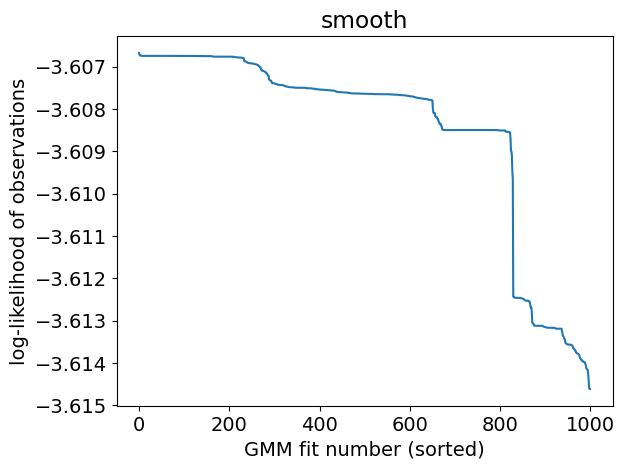

In [25]:
plt.figure()
plt.plot(S)
plt.ylabel('log-likelihood of observations')
plt.xlabel('GMM fit number (sorted)')
plt.show()

# III. Plot maps of regime mean

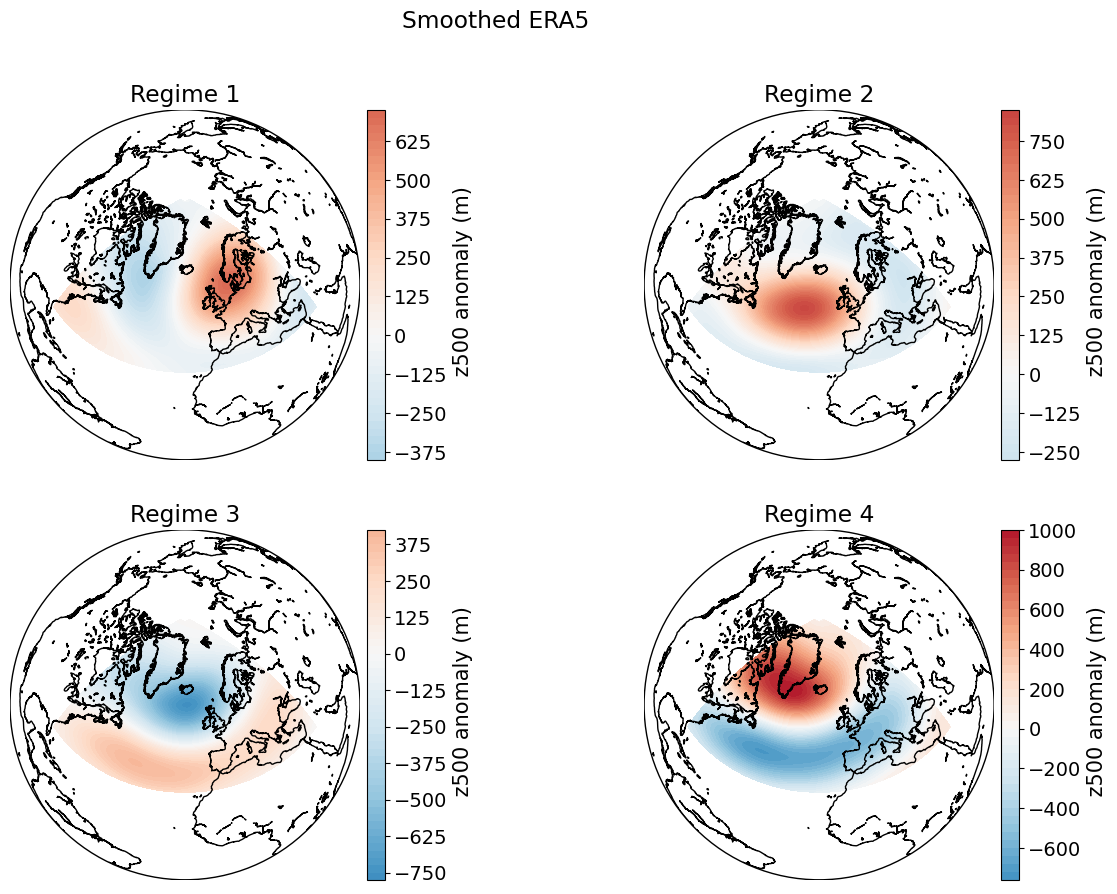

In [79]:
plt.figure(figsize=(15,10))

# Orthogonal projection (for large zone)
m=Basemap(projection='ortho',lat_0=60,lon_0=-20,resolution='l')

# transform (lon, lat) to (x, y) in the chosen projection
x, y = m(LON, LAT)

# plot the 2 first EOFs
for i in range(4):
    plt.subplot(2,2,i+1)
    m.contourf(x, y, (eofs[:ndim_gmm].T*np.sqrt(eigenval[:ndim_gmm])*means[i]).T.sum(dim='mode'),
               cmap = 'RdBu_r', vmin = -1250, vmax=1250, 
               levels=50)
    m.drawcoastlines()
    cb = m.colorbar(location="right")
    cb.set_label(" z500 anomaly (m)", fontsize=15)
    plt.title("Regime " + str(i+1))
plt.show()

Add percentage of regime attribution + litterature names.

In [26]:
# Name by hand with respect to litterature names
if smooth:
    change_order = [2,0,3,1]
else:
    change_order = [0,1,2,3] # CHANGE (note: problem with atlantic ridge: reversed!)
regime_names = np.array(['NAO +' , 'Scandinavian Blocking' , 'NAO -' , 'Atlantic Ridge'])#[change_order]
regime_short_names = np.array(['NAO +' , 'SB' , 'NAO -' , 'AR'])#[change_order]
means_ordered = means[change_order]
covs_ordered = covs[change_order]
weights_ordered = weights[change_order]

In [27]:
reverse_order = [0,0,0,0]
for j in range(nclus):
    reverse_order[j] = np.argwhere(np.array(change_order)==j)[0][0]

In [28]:
# repeat fit
gm_best = GMM(n_components=nclus, covariance_type=cov_type,
             random_state = sort_llik[0]).fit(np.array(pcs_norm[:,:ndim_gmm]))

In [29]:
regime_attribution = gm_best.predict(np.array(pcs_norm[:,:ndim_gmm]))
for i in range(len(regime_attribution)):
    regime_attribution[i] = reverse_order[regime_attribution[i]]

In [30]:
regime_attribution_distance = np.zeros_like(regime_attribution)
for i in tqdm(range(len(pcs_norm))):
    regime_attribution_distance[i] = np.argmin( 
            np.sum( (np.array(pcs_norm[i,:ndim_gmm]) - means_ordered)**2, axis=1)
                                                )

  0%|          | 0/8050 [00:00<?, ?it/s]

In [31]:
Ndays = np.zeros(nclus)
Ndays_kmeans = np.zeros(nclus)
Ndays_tot = int(len(pcs_norm)/2)
for i in range(nclus):
    Ndays[i] = int( np.sum( regime_attribution == i ) / 2 )
    Ndays_kmeans[i] = int( np.sum( regime_attribution_distance == i ) / 2 )    

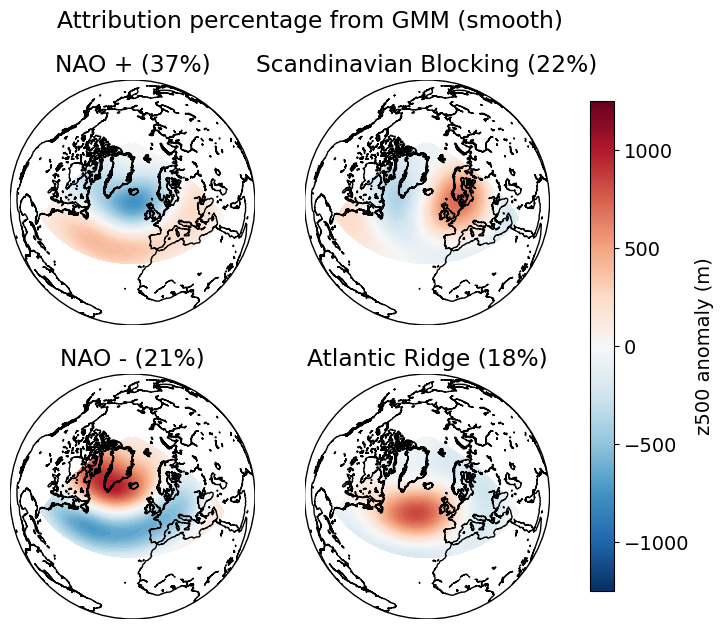

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2 , figsize=(8,7))

# Orthogonal projection (for large zone)
m=Basemap(projection='ortho',lat_0=60,lon_0=-20,resolution='l')

# transform (lon, lat) to (x, y) in the chosen projection
x, y = m(LON, LAT)

# plot the 2 first EOFs
for i in range(4):
    plt.subplot(2,2,i+1)
    m.contourf(x, y, (eofs[:ndim_gmm].T*np.sqrt(eigenval[:ndim_gmm])*means_ordered[i]).T.sum(dim='mode'),
               cmap = 'RdBu_r', norm=mpl.colors.Normalize(vmin=-1250, vmax=1250),
               levels=50)
    m.drawcoastlines()
    plt.title(regime_names[i] + ' (' + str(int(100*Ndays[i]/Ndays_tot)) + '%)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])   
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1250, vmax=1250),
                                           cmap="RdBu_r"), cax=cbar_ax, label='z500 anomaly (m)')#, ax=ax)
plt.suptitle('Attribution percentage from GMM '+ smooth*'(smooth)' + (1-smooth)*'(unsmooth)' )
plt.savefig('../outputs/figures/regimes_GMMattribution_'+ smooth*'smooth' + (1-smooth)*'unsmooth' +'.png', dpi=150, bbox_inches ="tight",)
plt.show()

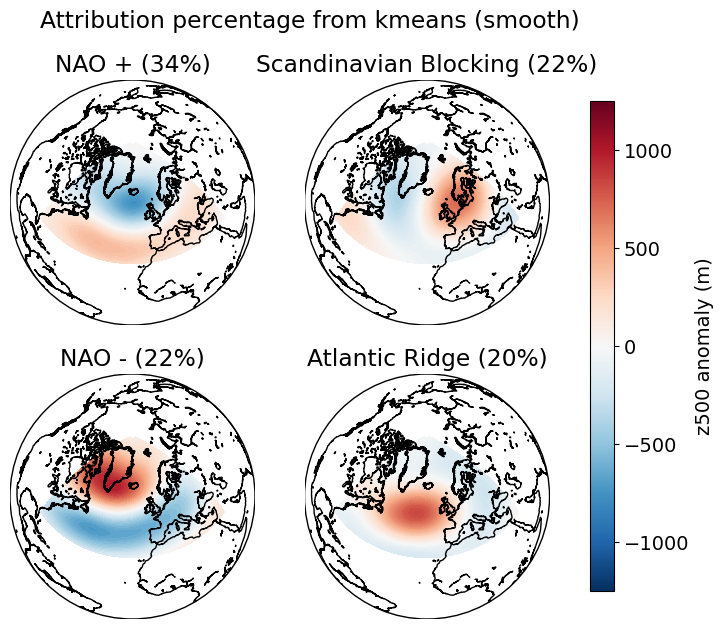

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2 , figsize=(8,7))

# Orthogonal projection (for large zone)
m=Basemap(projection='ortho',lat_0=60,lon_0=-20,resolution='l')

# transform (lon, lat) to (x, y) in the chosen projection
x, y = m(LON, LAT)

# plot the 2 first EOFs
for i in range(4):
    plt.subplot(2,2,i+1)
    m.contourf(x, y, (eofs[:ndim_gmm].T*np.sqrt(eigenval[:ndim_gmm])*means_ordered[i]).T.sum(dim='mode'),
               cmap = 'RdBu_r', norm=mpl.colors.Normalize(vmin=-1250, vmax=1250), levels=50)
    m.drawcoastlines()
    plt.title(regime_names[i] + ' (' + str(int(100*Ndays_kmeans[i]/Ndays_tot)) + '%)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])   
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1250, vmax=1250),
                                           cmap="RdBu_r"), cax=cbar_ax, label='z500 anomaly (m)')#, ax=ax)
plt.suptitle('Attribution percentage from kmeans '+ smooth*'(smooth)' + (1-smooth)*'(unsmooth)')
plt.savefig('../outputs/figures/regimes_KMEANSattribution_'+ smooth*'smooth' + (1-smooth)*'unsmooth' +'.png', dpi=150, bbox_inches ="tight",)
plt.show()

In [34]:
# Save
filename_params = '../outputs/data/GMM_params_' + smooth*'smooth' + (1-smooth)*'unsmooth' + '.npz'
np.savez(filename_params, means = means, covs = covs, weights = weights,
        nclus = nclus, cov_type = cov_type, ndim_gmm = ndim_gmm, random_state_gmm = sort_llik[0],
        regime_names = np.array(regime_names),
        regime_short_names = np.array(regime_short_names),
        regime_attribution = regime_attribution,
        regime_attribution_distance = regime_attribution_distance,
        Ndays = Ndays, Ndays_kmeans = Ndays_kmeans, Ndays_tot = Ndays_tot, smooth = smooth)